Testing BFS Solver...
✓ Test 1 passed: Already solved puzzle
✓ Test 2 passed: 1-move solution
✓ Test 3 passed: Random puzzle solved in 2 moves
All BFS solver tests passed! ✅

Creating dataset...
✓ Created puzzle1 (2 moves, 1 optimal solution, 3 blockers)
✓ Created puzzle1_90_rotation (2 moves, 1 optimal solution, 3 blockers)
✓ Created puzzle1_180_rotation (2 moves, 1 optimal solution, 3 blockers)
✓ Created puzzle1_270_rotation (2 moves, 1 optimal solution, 3 blockers)
✓ Created puzzle1_horizontal_flip (2 moves, 1 optimal solution, 3 blockers)
✓ Created puzzle1_vertical_flip (2 moves, 1 optimal solution, 3 blockers)
✓ Created puzzle2 (3 moves, 1 optimal solution, 3 blockers)
✓ Created puzzle2_90_rotation (3 moves, 1 optimal solution, 3 blockers)
✓ Created puzzle2_180_rotation (3 moves, 1 optimal solution, 3 blockers)
✓ Created puzzle2_270_rotation (3 moves, 1 optimal solution, 3 blockers)
✓ Created puzzle2_horizontal_flip (3 moves, 1 optimal solution, 3 blockers)
✓ Created puzzle2_verti

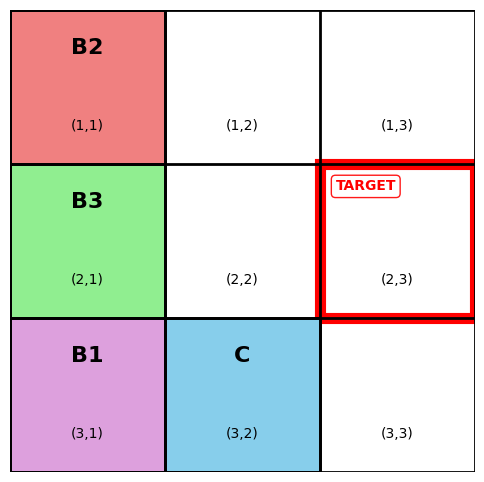

Example solution in 2 moves:
Step 1: C [3,2] -> [2,2]
Step 2: C [2,2] -> [2,3]

Note: Coordinates are 1-indexed to match the visual grid numbers

Example puzzle-specific prompt:
--------------------------------------------------
Task Description: You are given a 3x3 Rush Hour puzzle. Your goal is to move the blue car (labeled "C") from its current position [3,2] to the TARGET cell at position [2,3] by moving pieces one square at a time.

Puzzle Pieces:
- Car "C" (blue): Currently at position [3,2] - This is the piece you need to get to the TARGET
- Blockers (B1, B2, etc.): Obstacles that can be moved to clear a path
    - B2 at [1,1]
  - B3 at [2,1]
  - B1 at [3,1]
- TARGET cell: Position [2,3] (marked with red border and "TARGET" label)

Movement Rules:
- Any piece (car "C" or blockers "B1", "B2", etc.) can move UP, DOWN, LEFT, or RIGHT
- Each move is exactly ONE square in any direction
- Pieces strictly CANNOT move outside the 3x3 grid
- Pieces strictly CANNOT move into occupied squa

In [ ]:
# Rush Hour 3x3 Puzzle Generator + Verified BFS Solver + Dataset Creator

import random
import os
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# -------------------
# Puzzle representation:
#   - 3x3 grid (list of lists)
#   - 'C' = car, 'B#' = blocker, '.' = empty
# Exit is always to the right of row 1 (index 1)
# -------------------

GRID_SIZE = 3
EXIT_POS = (1, GRID_SIZE - 1)  # (row, col) of exit cell

# ----- Utility functions -----

def generate_random_puzzle(num_blockers=3, max_attempts=1000):
    """
    Generates a random puzzle with:
      - 1 car 'C' in a random position NOT at the exit.
      - num_blockers 1x1 blockers 'B1', 'B2', ...
      - 1 empty cell ('.')
    Only returns solvable puzzles.
    """
    for attempt in range(max_attempts):
        # All coordinates in grid
        coords = [(r, c) for r in range(GRID_SIZE) for c in range(GRID_SIZE)]
        
        # Place car (not at exit)
        available_for_car = [pos for pos in coords if pos != EXIT_POS]
        car_pos = random.choice(available_for_car)
        coords.remove(car_pos)
        
        # Place blockers
        blockers = {}
        for i in range(1, num_blockers + 1):
            if not coords:
                break
            pos = random.choice(coords)
            coords.remove(pos)
            blockers[f'B{i}'] = pos
        
        # Build grid
        grid = [['.' for _ in range(GRID_SIZE)] for _ in range(GRID_SIZE)]
        r, c = car_pos
        grid[r][c] = 'C'
        for b, pos in blockers.items():
            r, c = pos
            grid[r][c] = b
        
        # Test if solvable
        if bfs_solve(grid) is not None:
            return grid
    
    raise Exception(f"Could not generate solvable puzzle after {max_attempts} attempts")

def grid_to_tuple(grid):
    return tuple(tuple(row) for row in grid)

def tuple_to_grid(t):
    return [list(row) for row in t]

def find_pos(grid, label):
    for r in range(GRID_SIZE):
        for c in range(GRID_SIZE):
            if grid[r][c] == label:
                return (r, c)
    return None

def print_grid(grid):
    """Debug function to print grid state"""
    for row in grid:
        print(' '.join(f'{cell:2}' for cell in row))
    print()

# ----- BFS Solver (Verified) -----

def is_solved(grid):
    """Check if car 'C' is at the exit position"""
    car_pos = find_pos(grid, 'C')
    return car_pos == EXIT_POS

def get_neighbors(state):
    """Get all valid neighboring states from current state"""
    grid = tuple_to_grid(state)
    neighbors = []
    
    # Try moving each piece (car or blocker) in all 4 directions
    for r in range(GRID_SIZE):
        for c in range(GRID_SIZE):
            if grid[r][c] != '.':  # Found a piece
                label = grid[r][c]
                
                # Try all 4 directions
                for dr, dc in [(-1,0), (1,0), (0,-1), (0,1)]:  # up, down, left, right
                    nr, nc = r + dr, c + dc
                    
                    # Check if new position is valid and empty
                    if (0 <= nr < GRID_SIZE and 0 <= nc < GRID_SIZE and 
                        grid[nr][nc] == '.'):
                        
                        # Create new state
                        new_grid = [row[:] for row in grid]  # Deep copy
                        new_grid[nr][nc] = label
                        new_grid[r][c] = '.'
                        neighbors.append(grid_to_tuple(new_grid))
    
    return neighbors

def bfs_solve_all_optimal(start_grid):
    """
    BFS solver that returns ALL optimal solutions (same shortest length).
    Returns list of solution paths, each path is a list of states.
    """
    start_state = grid_to_tuple(start_grid)
    
    if is_solved(start_grid):
        return [[]]  # Already solved, one empty solution
    
    queue = deque([(start_state, [])])
    visited = {start_state: 0}  # state -> minimum steps to reach it
    solutions = []
    min_solution_length = None
    
    while queue:
        current_state, path = queue.popleft()
        current_steps = len(path)
        
        # If we found a longer path than minimum solution, stop
        if min_solution_length is not None and current_steps >= min_solution_length:
            continue
        
        # Get all possible next states
        for next_state in get_neighbors(current_state):
            next_steps = current_steps + 1
            
            # Check if this state leads to longer solution than we've found
            if min_solution_length is not None and next_steps >= min_solution_length:
                continue
                
            # Check if we've seen this state with fewer or equal steps
            if next_state in visited and visited[next_state] < next_steps:
                continue
                
            visited[next_state] = next_steps
            new_path = path + [next_state]
            
            # Check if this state is solved
            if is_solved(tuple_to_grid(next_state)):
                if min_solution_length is None:
                    min_solution_length = next_steps
                    solutions = [new_path]
                elif next_steps == min_solution_length:
                    solutions.append(new_path)
                # Don't add to queue if solved
            else:
                queue.append((next_state, new_path))
    
    return solutions if solutions else None

def bfs_solve(start_grid):
    """
    BFS solver that returns ONE optimal solution.
    Returns None if no solution exists.
    """
    all_solutions = bfs_solve_all_optimal(start_grid)
    return all_solutions[0] if all_solutions else None

# ----- Verification Functions -----

def verify_solution(start_grid, solution_path):
    """Verify that a solution path is valid"""
    if not solution_path:
        return is_solved(start_grid)
    
    current = grid_to_tuple(start_grid)
    
    for i, next_state in enumerate(solution_path):
        # Check that next_state is a valid neighbor of current
        valid_neighbors = get_neighbors(current)
        if next_state not in valid_neighbors:
            print(f"Invalid move at step {i+1}")
            return False
        current = next_state
    
    # Check final state is solved
    final_grid = tuple_to_grid(current)
    if not is_solved(final_grid):
        print("Final state is not solved")
        return False
    
    return True

def test_bfs_solver():
    """Test the BFS solver with known cases"""
    print("Testing BFS Solver...")
    
    # Test 1: Already solved puzzle
    solved_grid = [['B1', '.', '.'], 
                   ['B2', '.', 'C'], 
                   ['.', 'B3', '.']]
    solution = bfs_solve(solved_grid)
    assert solution == [], f"Test 1 failed: {solution}"
    print("✓ Test 1 passed: Already solved puzzle")
    
    # Test 2: Simple 1-move solution
    simple_grid = [['B1', '.', '.'], 
                   ['B2', 'C', '.'], 
                   ['.', 'B3', '.']]
    solution = bfs_solve(simple_grid)
    assert solution is not None and len(solution) == 1, f"Test 2 failed: {solution}"
    assert verify_solution(simple_grid, solution), "Test 2 verification failed"
    print("✓ Test 2 passed: 1-move solution")
    
    # Test 3: Generate and solve random puzzle
    random.seed(42)
    test_grid = generate_random_puzzle(num_blockers=4)
    solution = bfs_solve(test_grid)
    assert solution is not None, "Test 3 failed: No solution found"
    assert verify_solution(test_grid, solution), "Test 3 verification failed"
    print(f"✓ Test 3 passed: Random puzzle solved in {len(solution)} moves")
    
    print("All BFS solver tests passed! ✅\n")

# ----- Transformations -----

def rotate_90_clockwise(grid):
    """Rotate grid 90 degrees clockwise"""
    return [[grid[GRID_SIZE-1-j][i] for j in range(GRID_SIZE)] for i in range(GRID_SIZE)]

def flip_horizontal(grid):
    """Flip grid horizontally"""
    return [row[::-1] for row in grid]

def flip_vertical(grid):
    """Flip grid vertically"""
    return grid[::-1]

def get_transformed_exit_pos(transformation):
    """Get the exit position after transformation"""
    original_exit = (1, 2)  # (row, col)
    
    if transformation == "90_cw":
        return (2, 1)
    elif transformation == "180":
        return (1, 0) 
    elif transformation == "270_cw":
        return (0, 1)
    elif transformation == "flip_h":
        return (1, 0)
    elif transformation == "flip_v":
        return (1, 2)
    else:  # original
        return (1, 2)

def apply_transformation(grid, transformation):
    """Apply transformation and update exit position"""
    if transformation == "original":
        return grid, (1, 2)
    elif transformation == "90_cw":
        new_grid = rotate_90_clockwise(grid)
        return new_grid, (2, 1)
    elif transformation == "180":
        new_grid = rotate_90_clockwise(rotate_90_clockwise(grid))
        return new_grid, (1, 0)
    elif transformation == "270_cw":
        new_grid = rotate_90_clockwise(rotate_90_clockwise(rotate_90_clockwise(grid)))
        return new_grid, (0, 1)
    elif transformation == "flip_h":
        new_grid = flip_horizontal(grid)
        return new_grid, (1, 0)
    elif transformation == "flip_v":
        new_grid = flip_vertical(grid)
        return new_grid, (1, 2)

# ----- Visualization -----

def draw_grid(grid, title="", save_path=None, exit_pos=None):
    """Draw grid and optionally save to file"""
    if exit_pos is None:
        exit_pos = EXIT_POS
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, GRID_SIZE)
    ax.set_ylim(0, GRID_SIZE)
    ax.set_xticks(range(GRID_SIZE + 1))
    ax.set_yticks(range(GRID_SIZE + 1))
    
    # Bold grid lines
    for x in range(GRID_SIZE + 1):
        ax.plot([x, x], [0, GRID_SIZE], color='black', linewidth=2)
    for y in range(GRID_SIZE + 1):
        ax.plot([0, GRID_SIZE], [y, y], color='black', linewidth=2)

    if title:
        ax.set_title(title, fontsize=16, pad=15)
    ax.invert_yaxis()

    # Draw TARGET border (no fill)
    er, ec = exit_pos
    ax.add_patch(
        patches.Rectangle((ec, er), 1, 1,
                          facecolor='none',
                          edgecolor='red', linewidth=8, linestyle='-')
    )

    # Assign colors for pieces
    colors = {'C': 'skyblue'}
    color_palette = ['lightcoral', 'lightgreen', 'plum', 'khaki', 'lightsalmon']
    blocker_count = 0
    for r in range(GRID_SIZE):
        for c in range(GRID_SIZE):
            cell = grid[r][c]
            if cell.startswith('B') and cell not in colors:
                colors[cell] = color_palette[blocker_count % len(color_palette)]
                blocker_count += 1

    # Draw pieces and coordinates
    for r in range(GRID_SIZE):
        for c in range(GRID_SIZE):
            cell = grid[r][c]
            
            # Draw piece if present
            if cell != '.':
                ax.add_patch(
                    patches.Rectangle((c, r), 1, 1,
                                      facecolor=colors.get(cell, 'white'),
                                      edgecolor='black', linewidth=2)
                )
                # Draw piece label in upper part of cell
                ax.text(c + 0.5, r + 0.25, cell, ha='center', va='center',
                        fontsize=16, fontweight='bold')
            
            # Always draw coordinates in lower part of cell (1-indexed)
            coord_text = f"({r+1},{c+1})"
            ax.text(c + 0.5, r + 0.75, coord_text, ha='center', va='center',
                    fontsize=10, color='black')

    # Add TARGET label in corner of target cell
    ax.text(ec + 0.1, er + 0.1, 'TARGET', ha='left', va='top',
            fontsize=10, fontweight='bold', color='red',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, edgecolor='red'))

    ax.axis('off')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
        plt.close()
    else:
        plt.show()

# ----- Solution Text Generation -----

def generate_solution_moves(start_grid, solution_path, exit_pos=None):
    """Generate text description of solution moves with 1-indexed coordinate system"""
    if exit_pos is None:
        exit_pos = EXIT_POS
    
    moves = []
    current_grid = start_grid
    
    for i, next_state in enumerate(solution_path):
        next_grid = tuple_to_grid(next_state)
        
        # Find what moved
        moved_piece = None
        old_pos = None
        new_pos = None
        
        # Find differences between current and next state
        for r in range(GRID_SIZE):
            for c in range(GRID_SIZE):
                if current_grid[r][c] != next_grid[r][c]:
                    if current_grid[r][c] != '.' and next_grid[r][c] == '.':
                        # This piece moved away
                        moved_piece = current_grid[r][c]
                        old_pos = (r, c)
                    elif current_grid[r][c] == '.' and next_grid[r][c] != '.':
                        # This piece moved here
                        new_pos = (r, c)
        
        if moved_piece and old_pos and new_pos:
            # Convert to 1-indexed coordinates to match visual grid
            old_pos_1indexed = (old_pos[0] + 1, old_pos[1] + 1)
            new_pos_1indexed = (new_pos[0] + 1, new_pos[1] + 1)
            moves.append(f"Step {i+1}: {moved_piece} [{old_pos_1indexed[0]},{old_pos_1indexed[1]}] -> [{new_pos_1indexed[0]},{new_pos_1indexed[1]}]")
        
        current_grid = next_grid
    
    return moves

# ----- Prompt Generation -----

def generate_puzzle_specific_prompt(grid, exit_pos=None):
    """Generate a customized prompt for the specific puzzle"""
    if exit_pos is None:
        exit_pos = EXIT_POS
    
    # Find car position
    car_pos = find_pos(grid, 'C')
    if car_pos is None:
        raise ValueError("No car 'C' found in grid")
    
    # Convert to 1-indexed coordinates
    car_pos_1indexed = (car_pos[0] + 1, car_pos[1] + 1)
    exit_pos_1indexed = (exit_pos[0] + 1, exit_pos[1] + 1)
    
    # Find blockers and their positions
    blockers = []
    for r in range(GRID_SIZE):
        for c in range(GRID_SIZE):
            cell = grid[r][c]
            if cell != '.' and cell != 'C':
                pos_1indexed = (r + 1, c + 1)
                blockers.append(f"{cell} at [{pos_1indexed[0]},{pos_1indexed[1]}]")
    
    prompt = f"""Task Description: You are given a 3x3 Rush Hour puzzle. Your goal is to move the blue car (labeled "C") from its current position [{car_pos_1indexed[0]},{car_pos_1indexed[1]}] to the TARGET cell at position [{exit_pos_1indexed[0]},{exit_pos_1indexed[1]}] by moving pieces one square at a time.

Puzzle Pieces:
- Car "C" (blue): Currently at position [{car_pos_1indexed[0]},{car_pos_1indexed[1]}] - This is the piece you need to get to the TARGET
- Blockers (B1, B2, etc.): Obstacles that can be moved to clear a path
  {chr(10).join(f"  - {blocker}" for blocker in blockers) if blockers else "  - None present"}
- TARGET cell: Position [{exit_pos_1indexed[0]},{exit_pos_1indexed[1]}] (marked with red border and "TARGET" label)

Movement Rules:
- Any piece (car "C" or blockers "B1", "B2", etc.) can move UP, DOWN, LEFT, or RIGHT
- Each move is exactly ONE square in any direction
- Pieces strictly CANNOT move outside the 3x3 grid
- Pieces strictly CANNOT move into occupied squares (i.e. squares that already have a blocker or the car)
- At ANY instant, there CANNOT be two pieces in the same square
- The same piece can move multiple times in a row if needed
- You win when car "C" reaches the TARGET cell

Strategy:
- The blockers may or may not be in your way - you may need to move them to create a clear path for the car
- Sometimes you need to move blockers temporarily to make space, then move them again
- Plan your moves carefully to avoid getting pieces stuck

Coordinate System:
- Use [row,col] format where [1,1] is top-left, [3,3] is bottom-right
- Each cell shows its coordinates in black text: (row,col)

Expected Output Format:
Wrap your solution in <solution> tags and provide it as a numbered list of moves in this exact format:

<solution>
Step 1: [PIECE] [start_position] -> [end_position]
Step 2: [PIECE] [start_position] -> [end_position]
...
</solution>

Example response format:
<solution>
Step 1: C [2,1] -> [2,2]
Step 2: B1 [1,3] -> [1,2]  
Step 3: C [2,2] -> [1,2]
</solution>"""

    return prompt
            

# ----- Dataset Generation -----

def create_dataset(num_puzzles=50, base_folder="data"):
    """Create comprehensive dataset with puzzles and transformations"""
    if not os.path.exists(base_folder):
        os.makedirs(base_folder)
    
    transformations = ["original", "90_rotation", "180_rotation", "270_rotation", "horizontal_flip", "vertical_flip"]
    transform_mapping = {
        "original": "original",
        "90_rotation": "90_cw",
        "180_rotation": "180", 
        "270_rotation": "270_cw",
        "horizontal_flip": "flip_h",
        "vertical_flip": "flip_v"
    }
    
    successful_puzzles = 0
    attempts = 0
    
    while successful_puzzles < num_puzzles:
        attempts += 1
        if attempts > num_puzzles * 10:  # Safety break
            print(f"Warning: Only generated {successful_puzzles} puzzles after {attempts} attempts")
            break
            
        try:
            # Generate base puzzle with varying difficulty
            random.seed(attempts * 137 + 42)  # Different seed each time
            num_blockers = random.choice([3, 4, 5])
            base_puzzle = generate_random_puzzle(num_blockers=num_blockers)
            
            puzzle_num = successful_puzzles + 1
            
            # Process each transformation
            for transform_name in transformations:
                transform_key = transform_mapping[transform_name]
                
                # Apply transformation
                transformed_grid, new_exit_pos = apply_transformation(base_puzzle, transform_key)
                
                # Temporarily update global EXIT_POS for this transformation
                global EXIT_POS
                old_exit_pos = EXIT_POS
                EXIT_POS = new_exit_pos
                
                try:
                    # Solve transformed puzzle and get ALL optimal solutions
                    all_solutions = bfs_solve_all_optimal(transformed_grid)
                    if all_solutions is None:
                        print(f"Skipping puzzle{puzzle_num}_{transform_name} - no solution")
                        continue
                    
                    # Create folder with proper naming
                    if transform_name == "original":
                        folder_name = f"puzzle{puzzle_num}"
                    else:
                        folder_name = f"puzzle{puzzle_num}_{transform_name}"
                    
                    puzzle_folder = os.path.join(base_folder, folder_name)
                    if not os.path.exists(puzzle_folder):
                        os.makedirs(puzzle_folder)
                    
                    # Generate and save puzzle-specific prompt
                    puzzle_prompt = generate_puzzle_specific_prompt(transformed_grid, new_exit_pos)
                    prompt_file = os.path.join(puzzle_folder, "prompt.txt")
                    with open(prompt_file, 'w') as f:
                        f.write(puzzle_prompt)
                    
                    # Save initial puzzle
                    initial_path = os.path.join(puzzle_folder, "initial_state.png")
                    draw_grid(transformed_grid, save_path=initial_path, exit_pos=new_exit_pos)
                    
                    # Process each optimal solution
                    for sol_idx, solution in enumerate(all_solutions):
                        # Create subfolder for each solution if multiple exist
                        if len(all_solutions) > 1:
                            sol_folder = os.path.join(puzzle_folder, f"solution_{sol_idx + 1}")
                            if not os.path.exists(sol_folder):
                                os.makedirs(sol_folder)
                        else:
                            sol_folder = puzzle_folder
                        
                        # Save solution steps
                        current_grid = transformed_grid
                        for step_num, next_state in enumerate(solution, 1):
                            step_grid = tuple_to_grid(next_state)
                            step_path = os.path.join(sol_folder, f"step_{step_num}.png")
                            draw_grid(step_grid, save_path=step_path, exit_pos=new_exit_pos)
                            current_grid = step_grid
                        
                        # Generate and save solution text
                        moves = generate_solution_moves(transformed_grid, solution, new_exit_pos)
                        
                        if len(all_solutions) > 1:
                            solution_file = os.path.join(sol_folder, "solution.txt")
                        else:
                            solution_file = os.path.join(puzzle_folder, "solution.txt")
                            
                        with open(solution_file, 'w') as f:
                            f.write(f"Puzzle: {folder_name}\n")
                            if len(all_solutions) > 1:
                                f.write(f"Solution variant: {sol_idx + 1} of {len(all_solutions)}\n")
                            f.write(f"Total moves: {len(solution)}\n")
                            # Convert exit position to 1-indexed for display
                            exit_1indexed = (new_exit_pos[0] + 1, new_exit_pos[1] + 1)
                            f.write(f"Exit position: [{exit_1indexed[0]},{exit_1indexed[1]}]\n")
                            f.write(f"Transformation: {transform_name}\n")
                            f.write(f"Coordinate system: [row,col] where [1,1] is top-left (matches visual grid)\n\n")
                            f.write("Solution:\n")
                            for move in moves:
                                f.write(move + "\n")
                    
                    # Create summary file if multiple solutions
                    if len(all_solutions) > 1:
                        summary_file = os.path.join(puzzle_folder, "solutions_summary.txt")
                        with open(summary_file, 'w') as f:
                            f.write(f"Puzzle: {folder_name}\n")
                            f.write(f"Total optimal solutions found: {len(all_solutions)}\n")
                            f.write(f"Optimal move count: {len(all_solutions[0])}\n")
                            exit_1indexed = (new_exit_pos[0] + 1, new_exit_pos[1] + 1)
                            f.write(f"Exit position: [{exit_1indexed[0]},{exit_1indexed[1]}]\n")
                            f.write(f"Transformation: {transform_name}\n\n")
                            f.write("All solutions are stored in separate subfolders:\n")
                            for i in range(len(all_solutions)):
                                f.write(f"- solution_{i + 1}/\n")
                    
                    solution_count = len(all_solutions)
                    print(f"✓ Created {folder_name} ({len(all_solutions[0])} moves, {solution_count} optimal solution{'s' if solution_count > 1 else ''}, {num_blockers} blockers)")
                    
                finally:
                    # Restore original exit position
                    EXIT_POS = old_exit_pos
            
            successful_puzzles += 1
            
        except Exception as e:
            print(f"Error generating puzzle {attempts}: {e}")
            continue
    
    print(f"\n🎉 Dataset creation complete!")
    print(f"Generated {successful_puzzles} base puzzles with transformations")
    print(f"Total puzzle variants: {successful_puzzles * len(transformations)}")
    print(f"Dataset saved in '{base_folder}' folder")

# ----- Main Execution -----

if __name__ == "__main__":
    # Verify BFS solver first
    test_bfs_solver()
    
    # Create dataset
    print("Creating dataset...")
    create_dataset(num_puzzles=50)
    
    # Show example
    print("\nGenerating example puzzle...")
    random.seed(0)
    example_puzzle = generate_random_puzzle(num_blockers=3)
    draw_grid(example_puzzle)
    
    solution = bfs_solve(example_puzzle)
    if solution:
        print(f"Example solution in {len(solution)} moves:")
        moves = generate_solution_moves(example_puzzle, solution)
        for move in moves:
            print(move)
        print("\nNote: Coordinates are 1-indexed to match the visual grid numbers")
        
        # Show example prompt
        print("\nExample puzzle-specific prompt:")
        print("-" * 50)
        example_prompt = generate_puzzle_specific_prompt(example_puzzle)
        print(example_prompt)